In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
OUT_PATH = 'data/'
CONS_PATH = OUT_PATH + 'consumptions.zip'
PROTOS_PATH = OUT_PATH + 'prototypesMEAN.zip'
STD_PATH = OUT_PATH + 'prototypesSTD.zip'

In [3]:
df = pd.read_pickle(CONS_PATH)
protos = pd.read_pickle(PROTOS_PATH)
stds = pd.read_pickle(STD_PATH)
df

,building_id,weekday,active,type,consumptions
day,,,,,
2011-07-27,27,2,True,2,"[17.0, 19.0, 18.35079465, 35.84631282, 47.8462..."
2011-07-28,27,3,True,2,"[18.88870418, 18.80300889, 18.84589226, 35.845..."
2011-07-29,27,4,True,2,"[20.0, 21.0, 20.0, 37.78877899, 45.84570469, 5..."
2011-07-30,27,5,False,1,"[17.29811321, 17.0, 17.23969745, 17.84583302, ..."
2011-07-31,27,6,False,1,"[18.84559887, 17.15385255, 18.0, 18.0, 18.0, 2..."
...,...,...,...,...,...
2020-05-09,2233,5,False,1,"[9.50106059, 8.96931442, 8.60189324, 9.1773389..."
2020-05-11,2233,0,False,1,"[8.57166388, 10.30621946, 10.4596744, 12.97239..."
2020-05-12,2233,1,False,1,"[8.31569322, 9.21411531, 10.19029213, 12.96810..."


In [4]:
def getConsumptions(proto: np.array, std: np.array) -> np.array:
    return np.random.normal(proto, np.multiply(std, 0.2))

In [5]:
def generate(first: datetime.datetime, last: datetime.datetime, consumer_type: int, active: bool, protos: pd.DataFrame, stds: pd.DataFrame) -> pd.Series:
    days = pd.date_range(start=first, end=last, freq='D')
    
    proto = protos[(protos['active'] == active) & (protos['type'] == consumer_type)]
    std = stds[(stds['active'] == active) & (stds['type'] == consumer_type)]
    
    consumptions = []
    for day in days:
        cons = getConsumptions(proto['consumptions'][proto['weekday'] == day.weekday()].tolist(), std['consumptions'][std['weekday'] == day.weekday()].tolist())
        
        for c in cons:
            for h in c:
                consumptions.append(h)
        
    return pd.Series(data=consumptions, index=pd.date_range(start=first, end=last, freq='1H'))

In [6]:
cons = generate(datetime.datetime(2020, 6, 23, 5), datetime.datetime(2020, 6, 30, 4), 0, True, protos, stds)
cons

2020-06-23 05:00:00    1.996427
2020-06-23 06:00:00    2.456259
2020-06-23 07:00:00    3.326605
2020-06-23 08:00:00    3.656542
2020-06-23 09:00:00    8.224586
                         ...   
2020-06-30 00:00:00    2.595753
2020-06-30 01:00:00    1.747678
2020-06-30 02:00:00    2.463870
2020-06-30 03:00:00    1.726187
2020-06-30 04:00:00    3.157412
Freq: H, Length: 168, dtype: float64

In [7]:
def applySmooth(df: pd.DataFrame, window_size: int = 4, times: int = 1) -> pd.DataFrame:
    for _ in range(times):
        df = df.rolling(window_size, min_periods=1, center=True).mean()
    
    return df

In [8]:
cons = applySmooth(cons, 4, 3)
cons

2020-06-23 05:00:00    2.484593
2020-06-23 06:00:00    2.664261
2020-06-23 07:00:00    3.007822
2020-06-23 08:00:00    3.721037
2020-06-23 09:00:00    4.774995
                         ...   
2020-06-30 00:00:00    3.264741
2020-06-30 01:00:00    2.867311
2020-06-30 02:00:00    2.581153
2020-06-30 03:00:00    2.402082
2020-06-30 04:00:00    2.330758
Freq: H, Length: 168, dtype: float64

In [9]:
proto = protos[(protos['type'] == 0) & (protos['active'])]

data = []
d = 0
while d < cons.shape[0]:
    consumptions = proto['consumptions'][proto['weekday'] == cons.index[d].weekday()].tolist()
    
    for conss in consumptions:
        for c in conss:
            data.append(c)
    
    d += 24

cons_proto = pd.Series(data=data, index=cons.index)

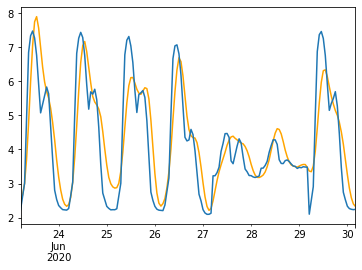

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

cons.plot(ax=ax, color='orange')
cons_proto.plot(ax=ax)